In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pwd

/content/drive


In [34]:
%ls

MyDrive/


In [35]:
%cd MyDrive/

/content/drive/MyDrive


In [36]:
%ls

 analysis.py                            'mom pic.jpg'
'Austria Documents'/                    'M. Sc Degree'/
'Bachelors Certification_Internships'/  'Music Production Journey (1).gsheet'
 CV.pdf                                 'Music Production Journey.gsheet'
 DataBase/                               pandas/
 Dataset/                                Passwords/
'Documents PDF'/                        'python projects.txt'
 DSC01322.JPG                            README.md
'IMG_9347  02-pc.jpg'                    video.mp4
'List notes_krishna.gdoc'                videos/
 Mercedes_kaggle/


In [37]:
%cd Mercedes_kaggle/

/content/drive/My Drive/Mercedes_kaggle


In [38]:
# Importing all necessary modules.
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import xgboost as xgb
from sklearn import ensemble
from sklearn.base import BaseEstimator,TransformerMixin,ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.utils import check_array
from sklearn.metrics import r2_score

# model evaluation
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel

# To make Results reproducible
seed = 40

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()
print("All packages successfully installed and imported")

All packages successfully installed and imported


In [39]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [40]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape : ", train.shape)
print("Test shape : ", test.shape)


Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [41]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))# Fit label encoder
        train[c] = lbl.transform(list(train[c].values))# Transform labels to normalized encoding.
        test[c] = lbl.transform(list(test[c].values))# Transform labels to normalized encoding.

# Dropping ID feature & creating saperate Input/Output training data.
train_y = train['y'].values
y_mean = np.mean(train_y)
id_test = test['ID'].values
train = train.drop(["ID"], axis=1)
test = test.drop(["ID"], axis=1)

# function to predict r2 score
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

# Save columns list before adding the decomposition components
usable_columns = list(set(train.columns) - set(['y']))

In [42]:
# Using Dimentionality reduction techniques to get the reduced features and adding
# them to the original features in the data set
n_comp = 15

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)
# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    
    train['tsvd_' + str(i)] = tsvd_results_train[:,i-1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i-1]
    
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]
    

In [43]:
# data from final_train and final_test are to be used only the stacked model 
# (does not contain PCA, ICA ) 

final_train = train[usable_columns].values
final_test = test[usable_columns].values

# Reference : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
import xgboost as xgb

# Prepare dict of params for xgboost model.
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth':5,
    'subsample': 0.9,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1}

# Creating DMatrices as object for Xgboost training
dtrain = xgb.DMatrix(train.drop(["y"], axis=1), train_y)
dtest = xgb.DMatrix(test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=1000,verbose_eval=50,show_stdv=False)

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# Train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
y_pred = model.predict(dtest)

[0]	train-rmse:12.6394	test-rmse:12.6385
[50]	train-rmse:11.05	test-rmse:11.1522
[100]	train-rmse:9.91707	test-rmse:10.1515
[150]	train-rmse:9.11908	test-rmse:9.49527
[200]	train-rmse:8.56302	test-rmse:9.07559
[250]	train-rmse:8.16727	test-rmse:8.81451
[300]	train-rmse:7.8844	test-rmse:8.65728
[350]	train-rmse:7.67453	test-rmse:8.56269
[400]	train-rmse:7.50814	test-rmse:8.51063
[450]	train-rmse:7.3557	test-rmse:8.48544
[500]	train-rmse:7.20829	test-rmse:8.47653
[550]	train-rmse:7.08536	test-rmse:8.47513
[600]	train-rmse:6.98077	test-rmse:8.4751
[650]	train-rmse:6.87375	test-rmse:8.4799
[700]	train-rmse:6.77469	test-rmse:8.48506
[750]	train-rmse:6.69071	test-rmse:8.4898
[800]	train-rmse:6.60836	test-rmse:8.49727
[850]	train-rmse:6.52697	test-rmse:8.50468
[900]	train-rmse:6.4508	test-rmse:8.51113
[950]	train-rmse:6.38417	test-rmse:8.51793
[999]	train-rmse:6.31922	test-rmse:8.52616
1000
[11:27:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in fav

In [44]:
# Train the stacked models then predict the test data !!
from sklearn.pipeline import make_pipeline, make_union

# Cross-validated Lasso, using the LARS algorithm
Stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001,loss="huber",max_features=0.55, 
                                                          min_samples_leaf=18, 
                                                          min_samples_split=14, subsample=0.7)),
    LassoLarsCV())



Stacked_pipeline.fit(final_train, train_y)
predictions = Stacked_pipeline.predict(final_test)

# R2 Score on the entire Train data when averaging
print('R2 score on train data:')
print(r2_score(train_y,Stacked_pipeline.predict(final_train)*0.2855 + model.predict(dtrain)*0.7145))

# Average the preditionon test data  of both models then save it on a csv file.

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred*0.75 + predictions*0.25
sub.to_csv('stacked_model_pred.csv', index=False)

R2 score on train data:
0.6794834464918559


Calculated R2 score: 0.679

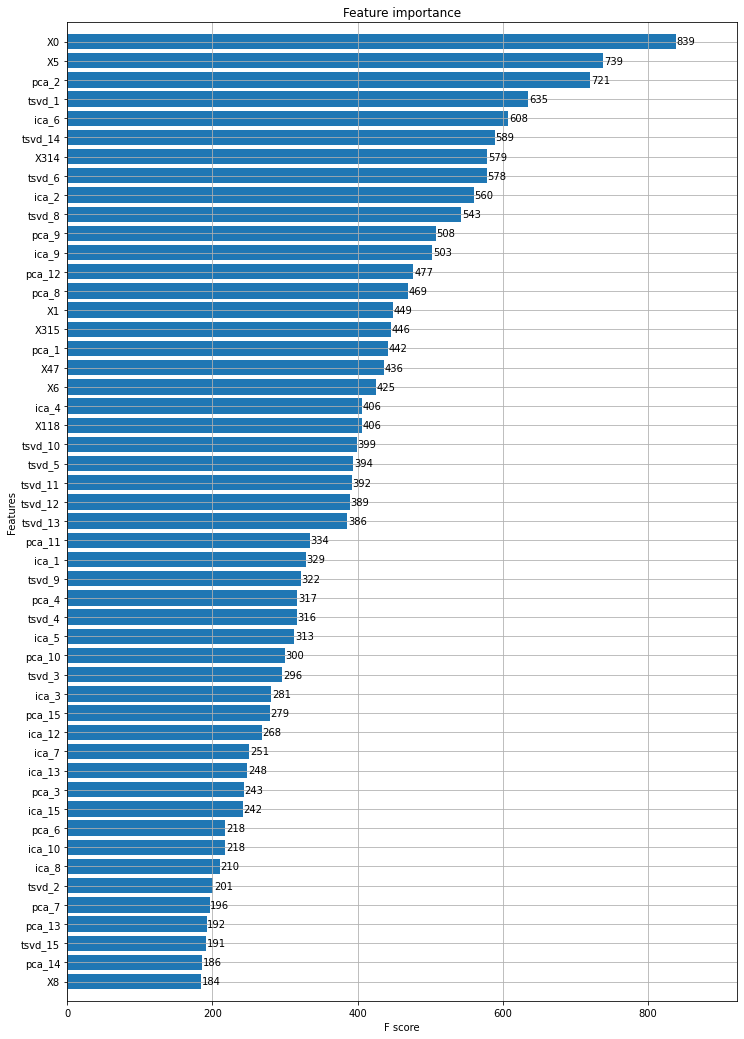

In [45]:
# Plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

**Observations:**
1.  X0 and X5 are very important features for the prediction in Xgboost model prediction
2. Additional features created through Dimentionality reduction techniques (Tsvd, PCA, ICA) also contributes effectivery
3. Improvement: Based on certain threhold number, less important features can be dropped which can consequently increase model time to predict target variable 'y'   



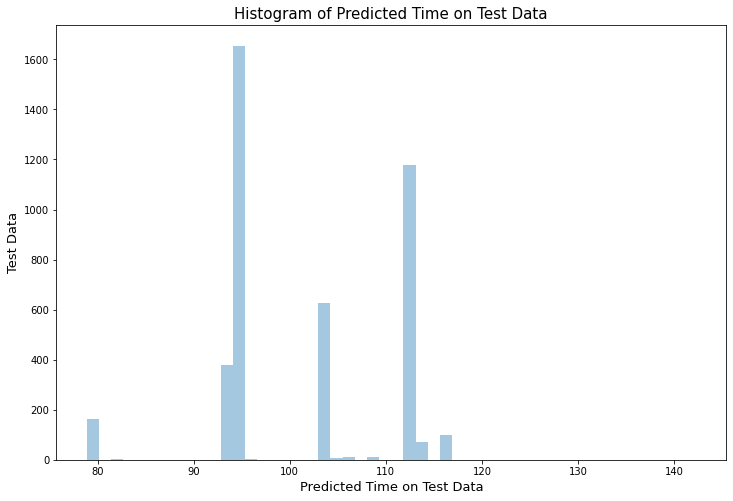

In [46]:
test = pd.read_csv('test.csv')

output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': predictions})

plt.figure(figsize=(12,8))
sns.distplot(output.y.values, bins=50, kde=False)
plt.xlabel('Predicted Time on Test Data', fontsize=13)
plt.ylabel('Test Data', fontsize=13)
plt.title('Histogram of Predicted Time on Test Data', fontsize=15)
plt.show()